삭제된 포스트 체크 하는 파일 

* 이슈  
    * postwithdeleted테이블에는 있지만 db에 있는 post테이블에는 없는 질의 응답 존재 
    * 예시 아이디 > 2335608
    * db에 있는 데이터와 SEDE에 있는 데이터를 짬뽕해서는 숫자를 맞출 수 없음 
    * 그래서 SEDE에 있는 데이터 만드로 확인 

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import re
from collections import deque
import datetime
import matplotlib.dates as mdates

In [2]:
postwithdeleted = pd.read_csv('../../data/postwithdeleted.csv')

In [3]:
postwithdeleted_pertype = pd.read_csv('../../data/postwithdeleted_pertype.csv')

In [128]:
deletedwithin = pd.read_csv('../../data/deletedwithin.csv')

In [4]:
# 파일 불러오기
with open('../../data/df_body.pkl', 'rb') as f:
    df_body = pickle.load(f)


In [5]:
df_body['date'] = df_body['creationdate'].dt.date
df_body['year'] = df_body['creationdate'].dt.year
df_body['month'] = df_body['creationdate'].dt.month
df_body['day'] = df_body['creationdate'].dt.day

In [6]:
# Q&A 만 추출 
df_body = df_body[df_body['posttypeid'].isin(['1','2'])]
df_qna_num = df_body.groupby(['date', 'posttypeid']).count()[['id']].reset_index()

In [7]:
df_bodycnt = df_body.groupby(['date', 'posttypeid']).count()[['id']].reset_index()

In [8]:
df_bodycnt = pd.pivot_table(df_bodycnt, index = 'date', columns = 'posttypeid', values = 'id').reset_index()

In [9]:
df_bodycnt

posttypeid,date,1,2
0,2013-11-01,5614.0,9372.0
1,2013-11-02,3314.0,5248.0
2,2013-11-03,3537.0,5489.0
3,2013-11-04,6188.0,9585.0
4,2013-11-05,6566.0,10671.0
...,...,...,...
3677,2023-11-26,1811.0,1522.0
3678,2023-11-27,3201.0,2601.0
3679,2023-11-28,3416.0,2809.0
3680,2023-11-29,3519.0,2869.0


In [10]:
postwithdeleted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22412 entries, 0 to 22411
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        22412 non-null  object
 1   posttypeid  22412 non-null  int64 
 2   del_yn      22412 non-null  object
 3   tot_cnt     22412 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 700.5+ KB


In [11]:
postwithdeleted['date_mod'] = pd.to_datetime(postwithdeleted['date'])


In [12]:
postwithdeleted = postwithdeleted.sort_values(by = ['date_mod'], ascending=True).reset_index(drop=True)

In [13]:
postwithdeleted_pivot = pd.pivot_table(data = postwithdeleted, index='date_mod', columns=['posttypeid', 'del_yn'], values = ['tot_cnt']).reset_index()

In [14]:
postwithdeleted_pivot.head()

date_mod tot_cnt                    
posttypeid                  1            2       
del_yn                      N     Y      N      Y
0          2008-07-31     4.0   2.0    2.0    4.0
1          2008-08-01    48.0  14.0   89.0  112.0
2          2008-08-02    25.0  22.0   68.0  197.0
3          2008-08-03    33.0  21.0   97.0  158.0
4          2008-08-04    77.0  49.0  238.0  465.0

In [15]:
postwithdeleted_pivot.columns

MultiIndex([('date_mod', '',  ''),
            ( 'tot_cnt',  1, 'N'),
            ( 'tot_cnt',  1, 'Y'),
            ( 'tot_cnt',  2, 'N'),
            ( 'tot_cnt',  2, 'Y')],
           names=[None, 'posttypeid', 'del_yn'])

In [16]:
postwithdeleted_pivot.columns = ['date_mod', 'q_cnt', 'q_d_cnt', 'a_cnt', 'a_d_cnt']

In [17]:
postwithdeleted_pivot.head()

,date_mod,q_cnt,q_d_cnt,a_cnt,a_d_cnt
0,2008-07-31,4.0,2.0,2.0,4.0
1,2008-08-01,48.0,14.0,89.0,112.0
2,2008-08-02,25.0,22.0,68.0,197.0
3,2008-08-03,33.0,21.0,97.0,158.0
4,2008-08-04,77.0,49.0,238.0,465.0


In [18]:
postwithdeleted_pivot['tot_d_cnt'] = postwithdeleted_pivot['q_d_cnt']+postwithdeleted_pivot['a_d_cnt']
postwithdeleted_pivot['tot_qna_cnt'] = postwithdeleted_pivot['q_cnt']+postwithdeleted_pivot['a_cnt']

In [19]:
postwithdeleted_pivot['tot_q_cnt'] = postwithdeleted_pivot['q_cnt']+postwithdeleted_pivot['q_d_cnt']
postwithdeleted_pivot['tot_a_cnt'] = postwithdeleted_pivot['a_cnt']+postwithdeleted_pivot['a_d_cnt']

In [20]:
postwithdeleted_pivot['ad_over_qd'] = postwithdeleted_pivot['a_d_cnt']/ postwithdeleted_pivot['q_d_cnt']

In [21]:
postwithdeleted_pivot = postwithdeleted_pivot[postwithdeleted_pivot['date_mod']>='2013-11-30']

### Number of Deleted Answer over Number of Deleted Question

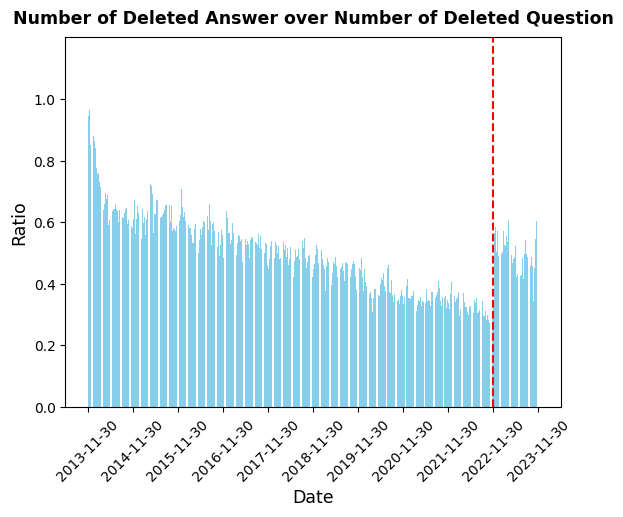

In [71]:
fig, ax = plt.subplots()


ax.bar(postwithdeleted_pivot.date_mod
    ,  height = postwithdeleted_pivot['ad_over_qd']
    ,  color = 'skyblue'
    ,  label = 'Mean'
    # ,  edgecolor = 'black'
      ) # hist type

ax.set_title("Number of Deleted Answer over Number of Deleted Question", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')
ax.set_xlabel("Date", # add x-axis label
              fontsize = 12.5)
ax.set_ylabel("Ratio", # add y-axis label
              fontsize = 12.5)

major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)

ax.axvline(['2022-11-30'], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
plt.xticks(rotation=45)
plt.show();

### Number of Question & Answer( Deleted+ Survived)

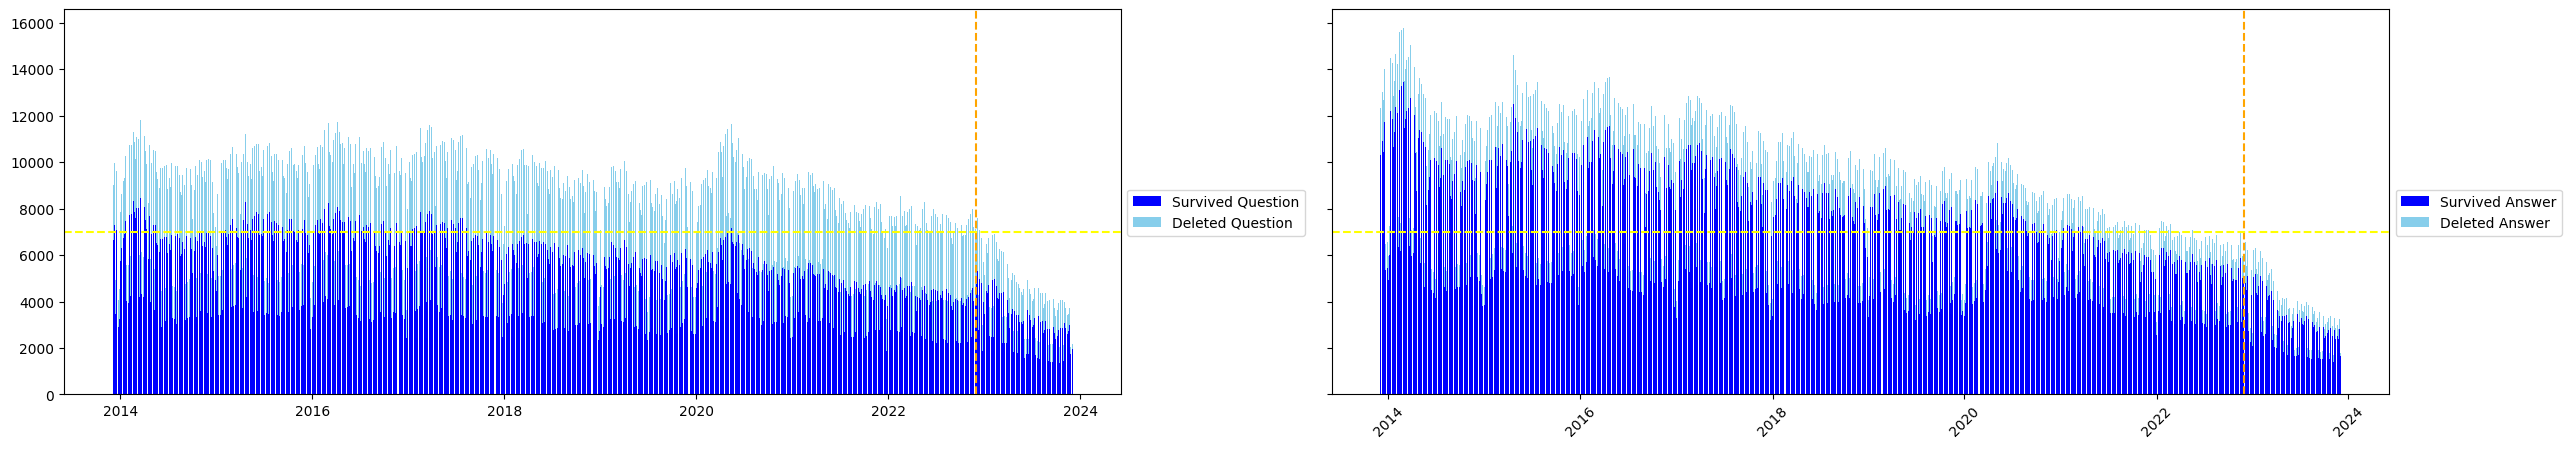

In [153]:
fig, ax = plt.subplots(1, 2, figsize = (30, 5), sharey=True, sharex=True)

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
ax[0].bar(postwithdeleted_pivot['date_mod'], postwithdeleted_pivot['q_cnt'], color='blue', label = 'Survived Question')
ax[0].bar(postwithdeleted_pivot['date_mod'], postwithdeleted_pivot['q_d_cnt'], bottom = postwithdeleted_pivot['q_cnt'], color = 'skyblue', label = 'Deleted Question')

ax[0].axvline([major_xticks[-2]], # add vertical line
           color = 'orange',
           linestyle = '--',
           linewidth = 1.5)

ax[0].axhline(7000, # add vertical line
           color = 'yellow',
           linestyle = '--',
           linewidth = 1.5)

ax[0].legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))


ax[1].bar(postwithdeleted_pivot['date_mod'], postwithdeleted_pivot['a_cnt'], color='blue', label = 'Survived Answer')
ax[1].bar(postwithdeleted_pivot['date_mod'], postwithdeleted_pivot['a_d_cnt'], bottom = postwithdeleted_pivot['a_cnt'], color = 'skyblue', label = 'Deleted Answer')

ax[1].axvline([major_xticks[-2]], # add vertical line
           color = 'orange',
           linestyle = '--',
           linewidth = 1.5)

ax[1].axhline(7000, # add vertical line
           color = 'yellow',
           linestyle = '--',
           linewidth = 1.5)

ax[1].legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))

plt.xticks(rotation = 45)
plt.show();
plt.show();

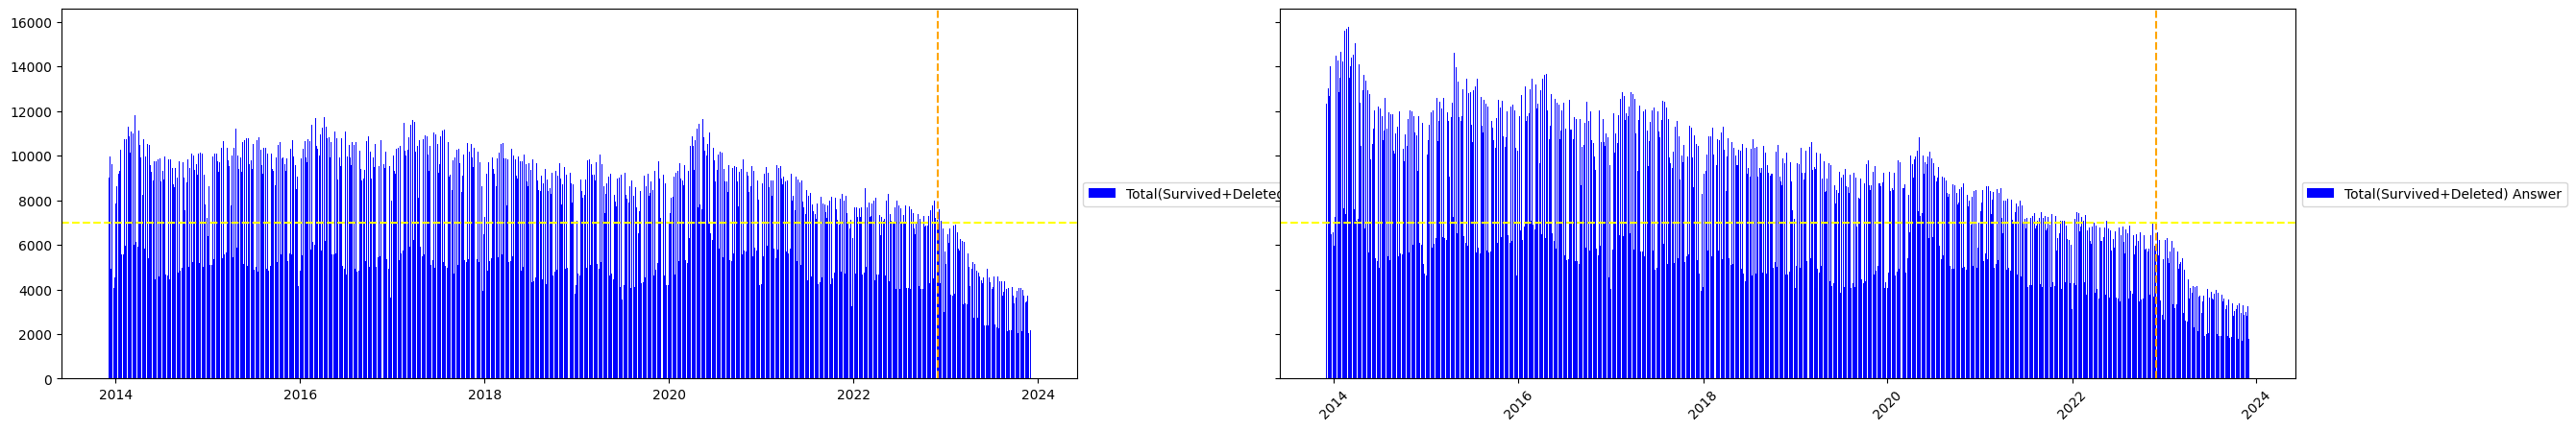

In [156]:
fig, ax = plt.subplots(1, 2, figsize = (30, 5), sharey=True, sharex=True)

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
ax[0].bar(postwithdeleted_pivot['date_mod'], postwithdeleted_pivot['q_cnt'] + postwithdeleted_pivot['q_d_cnt'], color='blue', label = 'Total(Survived+Deleted) Question')

ax[0].axvline([major_xticks[-2]], # add vertical line
           color = 'orange',
           linestyle = '--',
           linewidth = 1.5)

ax[0].axhline(7000, # add vertical line
           color = 'yellow',
           linestyle = '--',
           linewidth = 1.5)

ax[0].legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))


ax[1].bar(postwithdeleted_pivot['date_mod'], postwithdeleted_pivot['a_cnt'] + postwithdeleted_pivot['a_d_cnt'], color='blue', label = 'Total(Survived+Deleted) Answer')


ax[1].axvline([major_xticks[-2]], # add vertical line
           color = 'orange',
           linestyle = '--',
           linewidth = 1.5)

ax[1].axhline(7000, # add vertical line
           color = 'yellow',
           linestyle = '--',
           linewidth = 1.5)

ax[1].legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))

plt.xticks(rotation = 45)
plt.show();
plt.show();

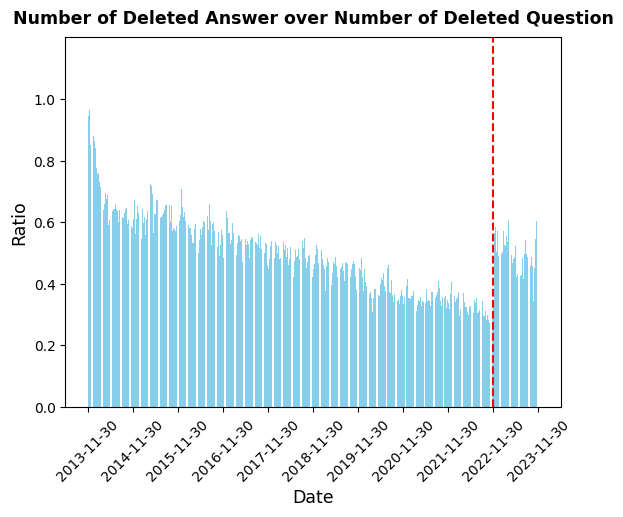

In [86]:
fig, ax = plt.subplots()


ax.bar(postwithdeleted_pivot.date_mod
    ,  height = postwithdeleted_pivot['ad_over_qd']
    ,  color = 'skyblue'
    ,  label = 'Mean'
    # ,  edgecolor = 'black'
      ) # hist type

ax.set_title("Number of Deleted Answer over Number of Deleted Question", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')
ax.set_xlabel("Date", # add x-axis label
              fontsize = 12.5)
ax.set_ylabel("Ratio", # add y-axis label
              fontsize = 12.5)

major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)

ax.axvline(['2022-11-30'], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
plt.xticks(rotation=45)
plt.show();

In [87]:
postwithdeleted_pivot['atot_over_qtot'] = postwithdeleted_pivot['tot_a_cnt']/ postwithdeleted_pivot['tot_q_cnt']

In [88]:
postwithdeleted_pivot['Date_num'] = np.arange(len(postwithdeleted_pivot.date_mod))

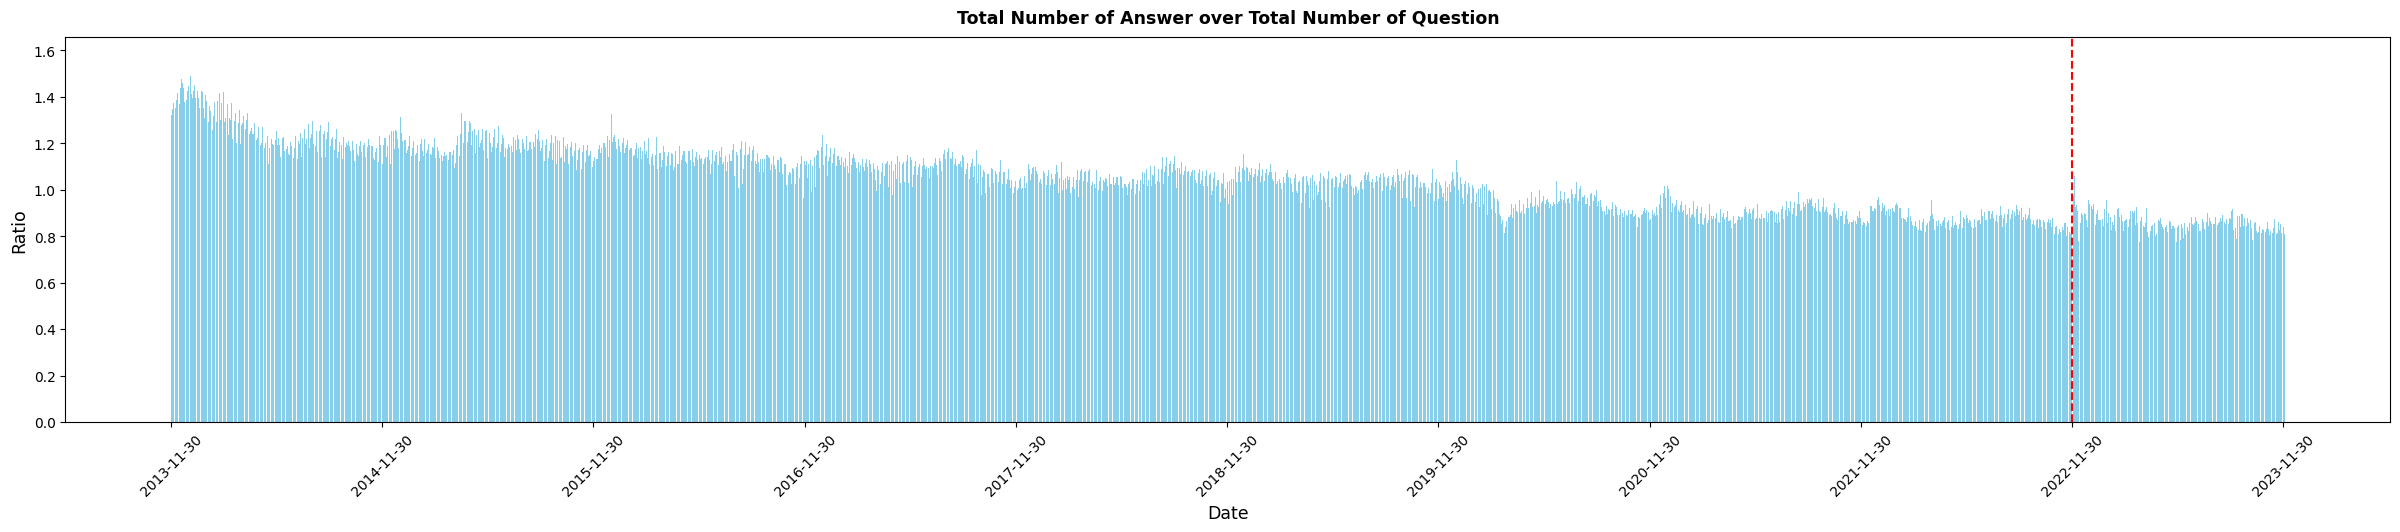

In [154]:
fig, ax = plt.subplots(figsize = (30, 5))


ax.bar(postwithdeleted_pivot.date_mod
    ,  height = postwithdeleted_pivot['atot_over_qtot']
    ,  color = 'skyblue'
    ,  label = 'Mean'
    # ,  edgecolor = 'black'
      ) # hist type

ax.set_title("Total Number of Answer over Total Number of Question", # add title
             fontsize = 12.5,
             weight = 'bold',
             pad = 10,
             loc = 'center')
ax.set_xlabel("Date", # add x-axis label
              fontsize = 12.5)
ax.set_ylabel("Ratio", # add y-axis label
              fontsize = 12.5)

major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
ax.set_xticks(major_xticks)

ax.axvline(['2022-11-30'], # add vertical line
           color = 'red',
           linestyle = '--',
           linewidth = 1.5)
plt.xticks(rotation=45)
plt.show();

In [25]:
postwithdeleted_pivot[postwithdeleted_pivot['date_mod']>= '2022-11-30'].head(20)

,date_mod,q_cnt,q_d_cnt,a_cnt,a_d_cnt,tot_d_cnt,tot_qna_cnt,tot_q_cnt,tot_a_cnt,ad_over_qd,atot_over_qtot
5235,2022-11-30,4190.0,3387.0,5331.0,1038.0,4425.0,9521.0,7577.0,6369.0,0.306466,0.840570
5236,2022-12-01,4285.0,3378.0,5153.0,1141.0,4519.0,9438.0,7663.0,6294.0,0.337774,0.821349
5237,2022-12-02,4759.0,1998.0,5026.0,1542.0,3540.0,9785.0,6757.0,6568.0,0.771772,0.972029
5238,2022-12-03,2935.0,1485.0,2989.0,1609.0,3094.0,5924.0,4420.0,4598.0,1.083502,1.040271
5239,2022-12-04,2913.0,1584.0,2950.0,1810.0,3394.0,5863.0,4497.0,4760.0,1.142677,1.058483
5240,2022-12-05,4957.0,2191.0,4816.0,1742.0,3933.0,9773.0,7148.0,6558.0,0.795071,0.917459
5241,2022-12-06,5299.0,2280.0,5240.0,1770.0,4050.0,10539.0,7579.0,7010.0,0.776316,0.924924
5242,2022-12-07,5001.0,2111.0,5138.0,1509.0,3620.0,10139.0,7112.0,6647.0,0.714827,0.934618
5243,2022-12-08,4868.0,1947.0,5030.0,1488.0,3435.0,9898.0,6815.0,6518.0,0.764253,0.956420
5244,2022-12-09,4261.0,1800.0,4499.0,1018.0,2818.0,8760.0,6061.0,5517.0,0.565556,0.910246


In [26]:
postwithdeleted_pertype['mod_date'] = pd.to_datetime(postwithdeleted_pertype['cdate'])

In [27]:
delete_pertype = postwithdeleted_pertype[~(postwithdeleted_pertype['dreason'] =='Ali')]

In [28]:
delete_pertype[['dreason', 'posttypeid']].drop_duplicates()

,dreason,posttypeid
0,Que,2
6,Ans,2
7,Que,1


In [29]:
delete_pertype = delete_pertype.sort_values(by = ['mod_date']).reset_index(drop=True)

In [38]:
delete_pertype = delete_pertype[delete_pertype['mod_date'] >= '2013-11-30']

In [39]:
cond1 = (delete_pertype['posttypeid'] == 1)
cond2 = (delete_pertype['posttypeid'] == 2)
cond3 = (delete_pertype['dreason'] == 'Ans')
cond4 = (delete_pertype['dreason'] == 'Que')


# 1 Que > cond1&cond4 
# 2 Que > cond2&cond4
# 2 Ans > cond2&cond3


In [40]:
delete_pertype.loc[cond2&cond3, 'mod_date'] >= '2013-11-30'

5844     True
5848     True
5850     True
5853     True
5858     True
         ... 
16796    True
16799    True
16800    True
16805    True
16807    True
Name: mod_date, Length: 3655, dtype: bool

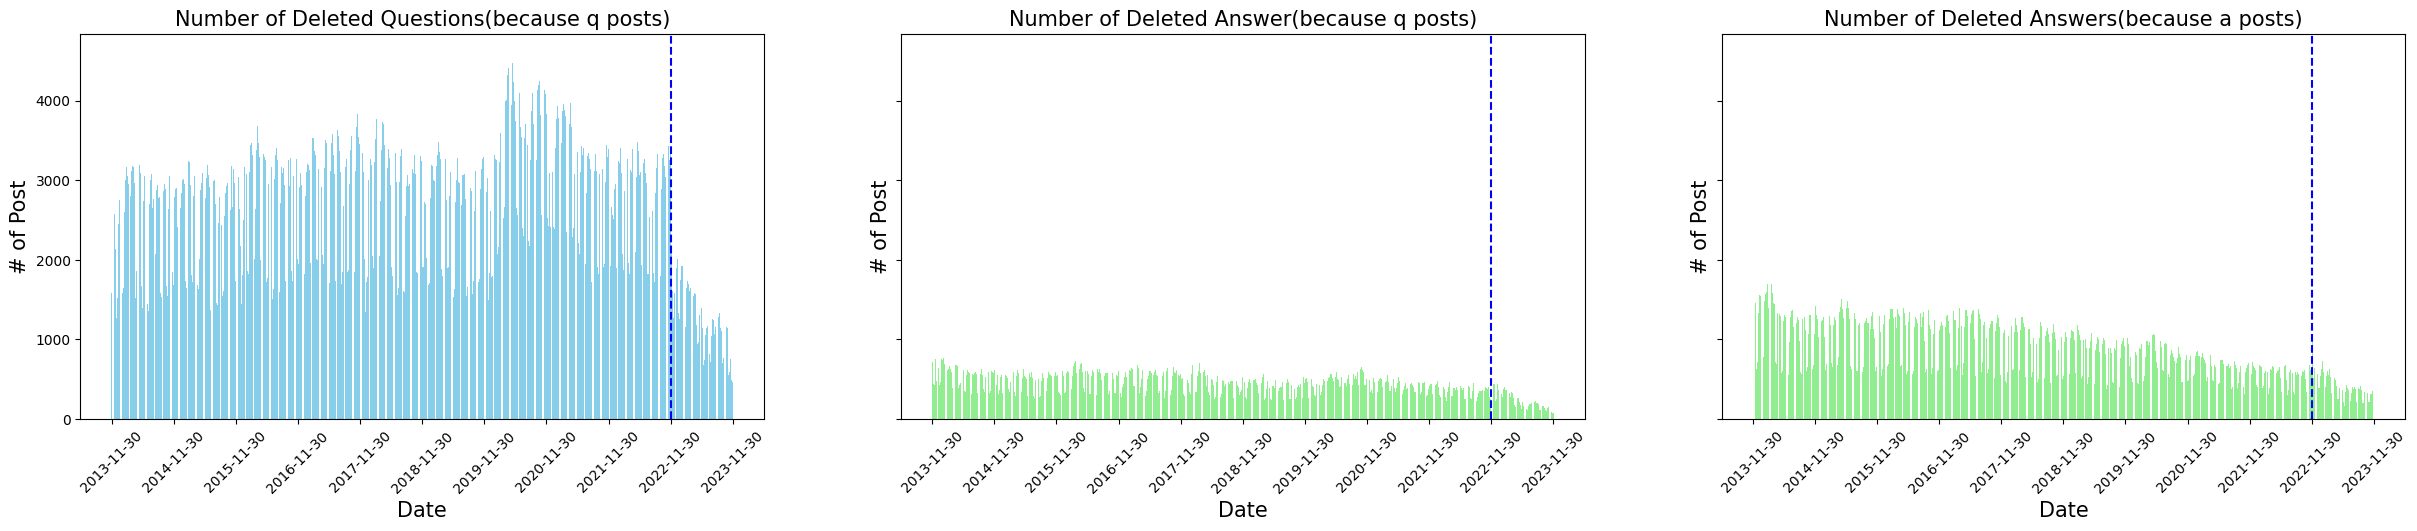

In [41]:
sharey = True ## 또는 sharey=False
sharex = True ## 또는 sharex=False

fig, axs = plt.subplots(1, 3, figsize = (30, 5), sharey=sharey, sharex=sharex)
# plt.xticks(rotation=45)
major_xticks = ['2013-11-30','2014-11-30','2015-11-30','2016-11-30','2017-11-30','2018-11-30','2019-11-30','2020-11-30'
                ,'2021-11-30', '2022-11-30', '2023-11-30']
# yticks = np.arange(200, 2000, 400)
axs[0].bar(delete_pertype[cond1&cond4 ].mod_date
        ,  height = delete_pertype[cond1&cond4 ].cnt
        ,  color = 'skyblue'
        # ,  edgecolor = 'black'
      ) # hist type

axs[0].set_title('Number of Deleted Questions(because q posts)', fontsize = 15)
axs[0].set_xlabel('Date', fontsize = 15)
axs[0].set_ylabel('# of Post', fontsize = 15)
axs[0].set_xticks(major_xticks)
# axs[0].set_yticks(yticks)
axs[0].axvline([major_xticks[-2]], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)
axs[0].tick_params(axis='x', rotation=45)
# axs[0].yticks(yt)

axs[1].bar(delete_pertype[cond2&cond4].mod_date
        ,  height = delete_pertype[cond2&cond4].cnt
        ,  color = 'lightgreen'
        # ,  edgecolor = 'black'
      ) # hist type

axs[1].set_title('Number of Deleted Answer(because q posts)', fontsize = 15)
axs[1].set_xlabel('Date', fontsize = 15)
axs[1].set_ylabel('# of Post', fontsize = 15)
axs[1].set_xticks(major_xticks)
# axs[1].set_yticks(yticks)
axs[1].axvline([major_xticks[-2]], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)
axs[1].tick_params(axis='x', rotation=45)

axs[2].bar(delete_pertype[cond2&cond3].mod_date
        ,  height = delete_pertype[cond2&cond3].cnt
        ,  color = 'lightgreen'
        # ,  edgecolor = 'black'
      ) # hist type

axs[2].set_title('Number of Deleted Answers(because a posts)', fontsize = 15)
axs[2].set_xlabel('Date', fontsize = 15)
axs[2].set_ylabel('# of Post', fontsize = 15)
axs[2].set_xticks(major_xticks)
# axs[1].set_yticks(yticks)
axs[2].axvline([major_xticks[-2]], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)
axs[2].tick_params(axis='x', rotation=45)



plt.show();


In [48]:

# 1 Que > cond1&cond4 
# 2 Que > cond2&cond4
# 2 Ans > cond2&cond3


delete_pertype['posttypeid'] = delete_pertype['posttypeid'].astype(str)

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_29006/1930231299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delete_pertype['posttypeid'] = delete_pertype['posttypeid'].astype(str)


In [51]:

delete_pertype['type_r'] = delete_pertype['posttypeid'] +delete_pertype['dreason']

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_29006/3438384819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delete_pertype['type_r'] = delete_pertype['posttypeid'] +delete_pertype['dreason']


In [56]:
delete_pertype_pivot = delete_pertype.pivot_table(index = 'mod_date', columns  = 'type_r', values='cnt').reset_index()
# ['type_r']

In [57]:
delete_pertype_pivot

type_r,mod_date,1Que,2Ans,2Que
0,2013-11-30,1582.0,756.0,436.0
1,2013-12-01,1529.0,640.0,449.0
2,2013-12-02,2544.0,1276.0,716.0
3,2013-12-03,2794.0,1446.0,862.0
4,2013-12-04,2812.0,1547.0,760.0
...,...,...,...,...
3650,2023-11-28,510.0,342.0,106.0
3651,2023-11-29,463.0,333.0,88.0
3652,2023-11-30,424.0,300.0,85.0
3653,2023-12-01,388.0,224.0,71.0


In [61]:
delete_pertype_pivot['tot_sum'] = delete_pertype_pivot[['1Que', '2Ans', '2Que']].sum(axis = 1)

In [65]:
delete_pertype_pivot['1Que_r'] = delete_pertype_pivot['1Que']/delete_pertype_pivot['tot_sum']*100
delete_pertype_pivot['2Que_r'] = delete_pertype_pivot['2Que']/delete_pertype_pivot['tot_sum']*100
delete_pertype_pivot['2Ans_r'] = delete_pertype_pivot['2Ans']/delete_pertype_pivot['tot_sum']*100

In [66]:
delete_pertype_pivot

type_r,mod_date,1Que,2Ans,2Que,tot_sum,1Que_r,2Que_r,2Ans_r
0,2013-11-30,1582.0,756.0,436.0,2774.0,57.029560,15.717376,27.253064
1,2013-12-01,1529.0,640.0,449.0,2618.0,58.403361,17.150497,24.446142
2,2013-12-02,2544.0,1276.0,716.0,4536.0,56.084656,15.784832,28.130511
3,2013-12-03,2794.0,1446.0,862.0,5102.0,54.762838,16.895335,28.341827
4,2013-12-04,2812.0,1547.0,760.0,5119.0,54.932604,14.846650,30.220746
...,...,...,...,...,...,...,...,...
3650,2023-11-28,510.0,342.0,106.0,958.0,53.235908,11.064718,35.699374
3651,2023-11-29,463.0,333.0,88.0,884.0,52.375566,9.954751,37.669683
3652,2023-11-30,424.0,300.0,85.0,809.0,52.410383,10.506799,37.082818
3653,2023-12-01,388.0,224.0,71.0,683.0,56.808199,10.395315,32.796486


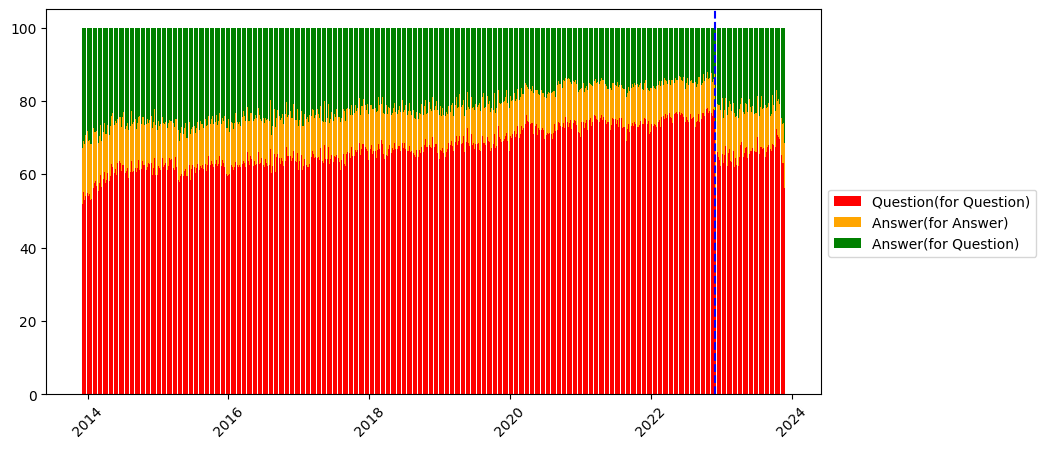

In [69]:
### Problem 2b: Reformat the data and generate the stacked bar plot above.


fig, ax = plt.subplots(figsize = (10, 5))

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
ax.bar(delete_pertype_pivot['mod_date'], delete_pertype_pivot['1Que_r'], color='red', label = 'Question(for Question)')
ax.bar(delete_pertype_pivot['mod_date'], delete_pertype_pivot['2Que_r'], bottom = delete_pertype_pivot['1Que_r'], color = 'orange', label = 'Answer(for Answer)')
ax.bar(delete_pertype_pivot['mod_date'], delete_pertype_pivot['2Ans_r'], bottom = delete_pertype_pivot['2Que_r'] + delete_pertype_pivot['1Que_r'], color = 'green', label = 'Answer(for Question)')

ax.axvline([major_xticks[-2]], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)

ax.legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))

plt.xticks(rotation = 45)
plt.show();

In [129]:
deletedwithin['date_mod'] = pd.to_datetime(deletedwithin['cdate'])

In [130]:
deletedwithin['deletedwithinamonth_r'] = deletedwithin['deletedwithinamonth']/deletedwithin['deletedpostcnt']*100
deletedwithin['deletedwithinaweek_r'] = deletedwithin['deletedwithinaweek']/deletedwithin['deletedpostcnt']*100

In [131]:
deletedwithin.sort_values(by = ['date_mod'], inplace = True)

In [132]:
deletedwithin = deletedwithin[deletedwithin['date_mod']>='2013-11-30']

In [145]:
deletedwithin_pivot = deletedwithin.pivot_table(index='date_mod', columns = ['posttypeid'], values = ['deletedwithinamonth_r', 'deletedwithinaweek_r'])

In [147]:
deletedwithin_pivot.index

DatetimeIndex(['2013-11-30', '2013-12-01', '2013-12-02', '2013-12-03',
               '2013-12-04', '2013-12-05', '2013-12-06', '2013-12-07',
               '2013-12-08', '2013-12-09',
               ...
               '2023-11-23', '2023-11-24', '2023-11-25', '2023-11-26',
               '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30',
               '2023-12-01', '2023-12-02'],
              dtype='datetime64[ns]', name='date_mod', length=3655, freq=None)

In [143]:
deletedwithin_pivot['deletedwithinamonth_r',1]  

0       51.256281
1       50.716146
2       47.654418
3       46.860589
4       47.598870
          ...    
3650    74.120407
3651    73.881204
3652    75.974026
3653    76.923077
3654    77.534562
Name: (deletedwithinamonth_r, 1), Length: 3655, dtype: float64

In [123]:
deletedwithin

,cdate,posttypeid,deletedpostcnt,deletedwithinamonth,deletedwithinaweek,date_mod,deletedwithinamonth_r,deletedwithinaweek_r
7338,2023-11-30 00:00:00,1,1232,936,501,2023-11-30,75.974026,40.665584
10825,2023-11-30 00:00:00,2,575,511,433,2023-11-30,88.869565,75.304348
43,2023-12-01 00:00:00,1,1131,870,486,2023-12-01,76.923077,42.970822
3113,2023-12-01 00:00:00,2,505,444,364,2023-12-01,87.920792,72.079208
1448,2023-12-02 00:00:00,2,355,314,254,2023-12-02,88.450704,71.549296
3790,2023-12-02 00:00:00,1,868,673,373,2023-12-02,77.534562,42.972350


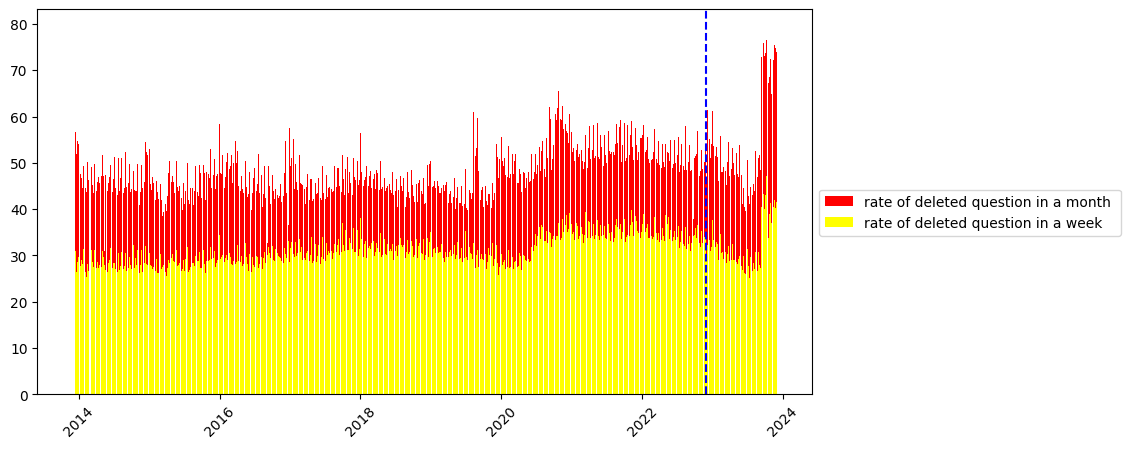

In [160]:
### Problem 2b: Reformat the data and generate the stacked bar plot above.


fig, ax = plt.subplots(figsize = (10, 5))

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
ax.bar(deletedwithin_pivot.index, deletedwithin_pivot['deletedwithinamonth_r',1]  , color='red', label =  'rate of deleted question in a month ')
ax.bar(deletedwithin_pivot.index, deletedwithin_pivot['deletedwithinaweek_r',1]  , color='yellow', label = 'rate of deleted question in a week')

ax.axvline([major_xticks[-2]], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)

ax.legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))

plt.xticks(rotation = 45)
plt.show();

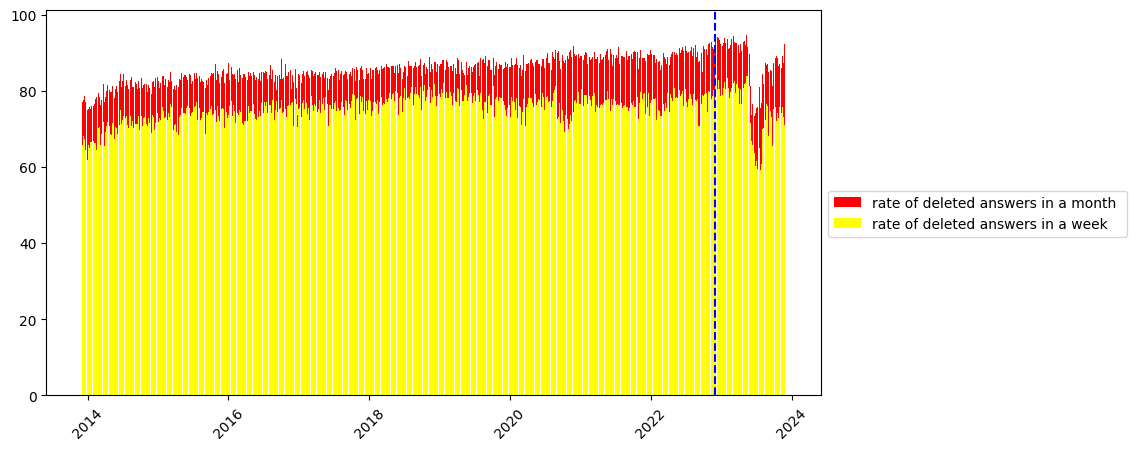

In [161]:
### Problem 2b: Reformat the data and generate the stacked bar plot above.


fig, ax = plt.subplots(figsize = (10, 5))

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
ax.bar(deletedwithin_pivot.index, deletedwithin_pivot['deletedwithinamonth_r',2]  , color='red', label = 'rate of deleted answers in a month ')
ax.bar(deletedwithin_pivot.index, deletedwithin_pivot['deletedwithinaweek_r',2]  , color='yellow', label = 'rate of deleted answers in a week')

ax.axvline([major_xticks[-2]], # add vertical line
           color = 'blue',
           linestyle = '--',
           linewidth = 1.5)

ax.legend( title_fontsize = 10, fontsize = 10,
          bbox_to_anchor = (1, 0.55))

plt.xticks(rotation = 45)
plt.show();